In [1]:
import celltypist
from celltypist import models

In [2]:
import scanpy as sc
import celltypist
import time
import numpy as np

In [3]:
import pandas as pd

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [6]:
def plot_confusion_matrix(confm, true_labels, all_labels, title, size=20, with_text=True):
    """
    Plot a confusion matrix.

    Parameters:
    - confm: Original confusion matrix
    - true_labels: List of true labels
    - all_labels: List of all labels in the order they appear in confm
    - title: Title of the plot
    - size: Size of the plot
    - with_text: Whether to include text in the cells
    """
    plt.figure(figsize=(size, size))

    # Extract relevant rows based on true labels
    confm_selected = cm[[labels.index(lab) for lab in true_labels]]

    # Normalize
    confm_selected = confm_selected.astype('float') / (confm_selected.sum(axis=1)[:, np.newaxis] + 1e-9)
    confm_selected = np.around(confm_selected, 4)

    ax = plt.subplot(1, 1, 1)
    plt.imshow(confm_selected, interpolation='nearest', cmap='Blues')

    if with_text:
        for i in range(len(confm_selected)):
            for j in range(len(confm_selected[0])):
                color = 'w' if confm_selected[i, j] > 0.5 else 'black'
                plt.text(j, i, confm_selected[i, j], ha="center", va="center", color=color)

    plt.title(title)
    plt.xticks(np.arange(len(all_labels)), all_labels, rotation=90)
    plt.yticks(np.arange(len(true_labels)), true_labels, rotation=0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

In [7]:
from sklearn.metrics import confusion_matrix

# Load reference data

In [8]:
adata = sc.read_h5ad("/nfs/public/cell_gpt_data/Intestine_heca1_2000.h5ad")
adata

AnnData object with n_obs × n_vars = 55214 × 2000
    obs: 'cid', 'seq_tech', 'donor_ID', 'donor_gender', 'donor_age', 'donor_status', 'original_name', 'organ', 'region', 'subregion', 'sample_status', 'treatment', 'ethnicity', 'cell_type', 'cell_id', 'study_id', 'train_test'

In [9]:
adata_train = adata[adata.obs['train_test'],:]
adata_test = adata[- adata.obs['train_test'],:]

# Train model

In [12]:
t_start = time.time()
model_fs = celltypist.train(adata_train, 'cell_type', n_jobs = 50, max_iter = 100,check_expression = False)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

🍳 Preparing data before training
✂️ 194 non-expressed genes are filtered out
🔬 Input data has 43929 cells and 1806 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!


Time elapsed: 17.336334228515625 seconds


In [13]:
model_fs.write('/nfs/public/cell_gpt_data/Test_data/celltypist_model/Intestine.1106.pkl')

# Validation

In [14]:
t_start = time.time()
predictions = celltypist.annotate(adata_test, model = '/nfs/public/cell_gpt_data/Test_data/celltypist_model/Intestine.1106.pkl', majority_voting = True)
t_end = time.time()
print(f"Time elapsed: {t_end - t_start} seconds")

⚠️ Warning: invalid expression matrix, expect all genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 11285 cells and 2000 genes
🔗 Matching reference genes in the model
🧬 1806 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/data/chenyx/anaconda3/envs/PICASSO/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/chenyx/anaconda3/envs/PICASSO/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning:

Time elapsed: 32.691221952438354 seconds


In [15]:
predictions

CellTypist prediction result for 11285 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 11285 query cells and 24 cell types
    probability_matrix: data frame with 11285 query cells and 24 cell types
    adata: AnnData object referred

<Figure size 2000x2000 with 0 Axes>

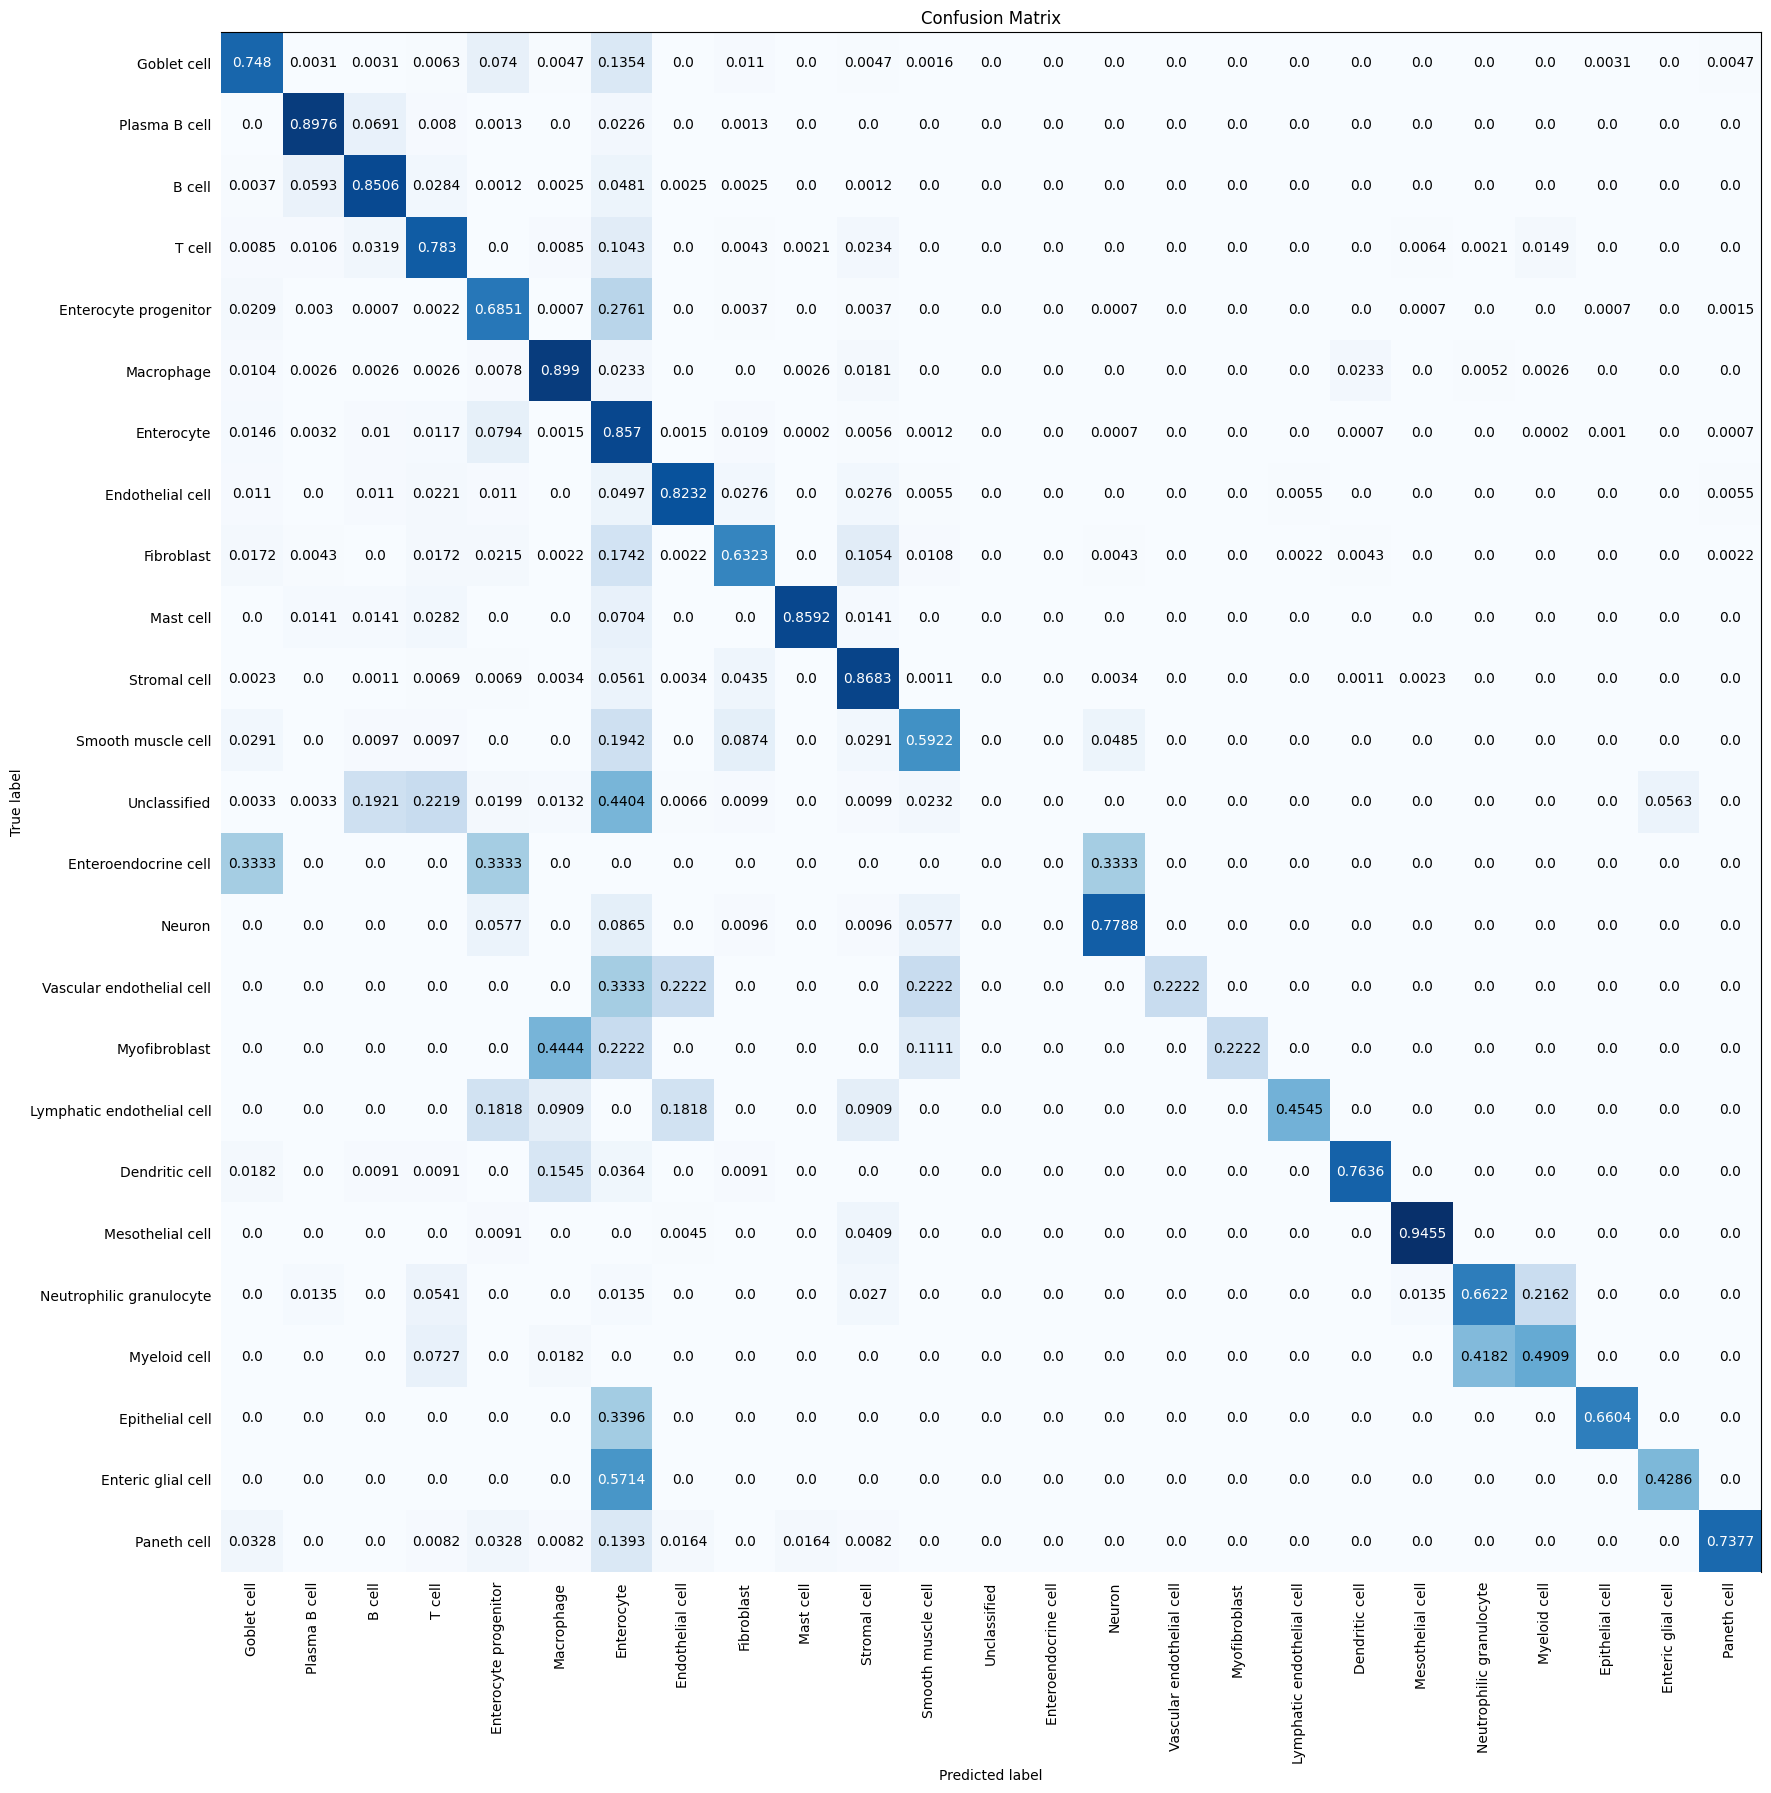

In [16]:
targets_ = list(adata_test.obs.cell_type.astype(str))
preds_ = list(predictions.predicted_labels.predicted_labels)
labels = list(Counter(targets_ + preds_).keys())
true_labels = list(Counter(targets_).keys())
cm = confusion_matrix(targets_, preds_, labels=labels)
plt.figure(figsize=(20, 20))
plot_confusion_matrix(cm, true_labels, labels, "Confusion Matrix")

In [18]:
accuracy = accuracy_score(targets_, preds_)
precision = precision_score(targets_, preds_, average="weighted")
recall = recall_score(targets_, preds_, average="macro")
weighted_f1 = f1_score(targets_, preds_, average="macro")

results = {
        "test/accuracy": accuracy,
        "test/precision": precision,
        "test/recall": recall,
        "test/weighted_f1": weighted_f1,
    }
print(results)

{'test/accuracy': 0.789720868409393, 'test/precision': 0.769980190983135, 'test/recall': 0.6344833501902541, 'test/weighted_f1': 0.6519895180615649}


/data/chenyx/anaconda3/envs/PICASSO/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/data/chenyx/anaconda3/envs/PICASSO/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea